# Data Mining Handin 2
This handin is about unsupervised methods for graph algorithms.

The handin is mandatory, and should be done in groups of 2-3 students. Each group
must prepare a report in PDF format as outlined below. Please submit all your
Python files in a zip file, and your PDF report outside the zip file, to
Blackboard no later than **April 7th kl. 14.14**.

In [1]:
import numpy as np
import networkx as nx
from scipy.linalg import fractional_matrix_power

%matplotlib inline
import matplotlib.pyplot as plt

# Local imports
import sys
sys.path.append('..')
from utilities.load_data import load_mnist

## 1. Theoretical questions

**Report section 1:**

1. Consider a (two-dimensional) dataset composed of two points
    1. Build a similarity matrix using a threshold function on Euclidean (norm-2) distance. The metric outputs 1 if the points are close enough according to a threshold and zero otherwise. Consider two cases: when the two datapoints are close or far.
    2. Build the Laplacian in each case and discuss the eigenvalues and eigenvectors.
2. What are the limitations of modualarity? 
3. Consider a dataset composed of four points with two pairs of points that are close to each other, one pair being far from the other. More formally, assume that the similarity matrix looks as follows:

$$
S=\left[\begin{array}{cccc}
1 & 0.8 & 0 & 0\\
0.8 & 1 & 0 & 0\\
0 & 0 & 1 & 0.5\\
0 & 0 & 0.5 & 1
\end{array}\right]
$$

What are the eigenvalues and eigenvectors of $L = D - S$? How many connected components do you obtain?

4. What is the PageRank of a complete graph with $n$ nodes? 
5. What is the PageRank of a complete bipartite graph with 2 nodes on one side and 4 on the other side and $\alpha=1$?  

## 2. Spectral clustering

We will now proceed with community detection algorithms. 
For this part of the hand in, we will try to cluster a subset of the MNIST data set.

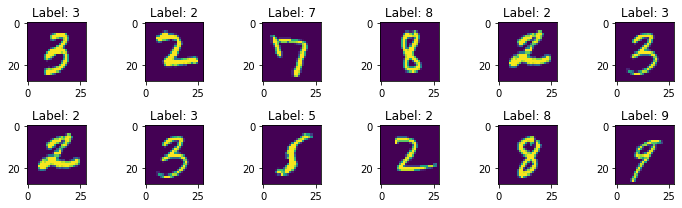

In [2]:
X_train, y_train, *_ = load_mnist()
np.random.seed(1)

n, h, w = X_train.shape
sel = np.random.permutation(n)
X = X_train[sel]
y = y_train[sel]

fig, ax = plt.subplots(2,6, figsize=(10, 3))
for i in range(2): 
    for j in range(6):
        ax[i, j].imshow(X[i*4 + j])
        ax[i, j].set_title("Label: %d" % y[i*4 + j])
plt.tight_layout()

**Report section 2:**  
1. Take the dataset and construct the $\varepsilon$-neighborhood graph, using Eucledian (L2) distance. Try with different epsilons and plot the graphs. What do you observe as epsilon increases? You can use the code below to plot the graph if you wish.
2. Compare the eigenvectors of the adjacency matrix, the normalized laplacian, and the random walk laplacian. Plot the eigenvectors of the different matrices. How do they relate? 
3. Run spectral clustering with the random walk and the normalized laplacian.
4. Record the performance with NMI. Provide a suitable implementation of NMI.  
5. There seem to be a relationship with spectral clustering and DBSCAN, what is that? Can you guess? _Hint_: Think about the $\varepsilon$-neighborhood graph constructed from the data.

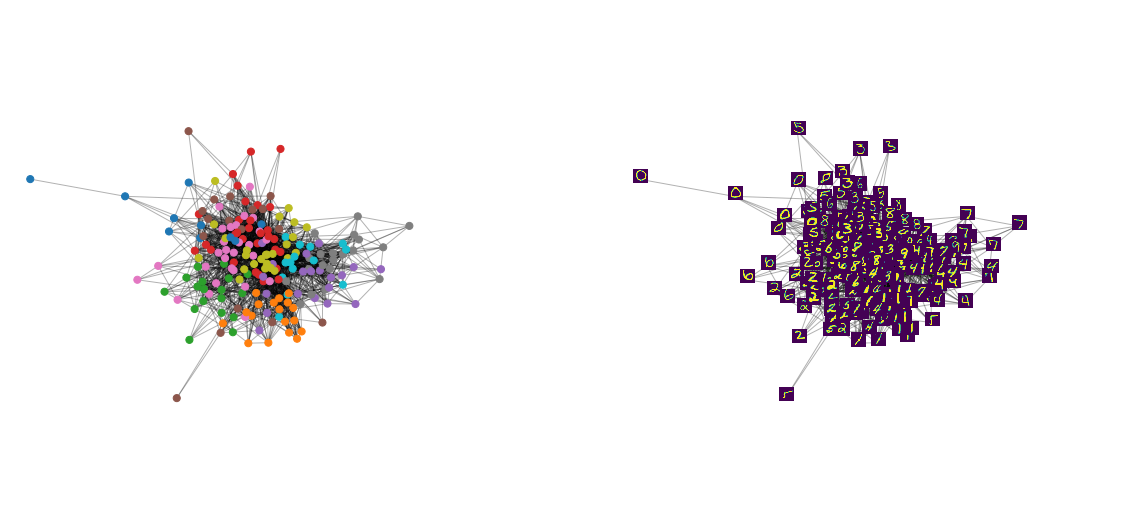

In [152]:
from sklearn.neighbors import NearestNeighbors

# Load 200 random samples from the MNIST training set.
X_ = X[:200].reshape(-1, 784)
X_ = (X_ - X_.mean(1, keepdims=True)) / X_.std(1, keepdims=True)
y_ = y[:200]

def plot_neighborhood_graph(G, pos, ax):
    ax.axis('off')
    ax.set_aspect('equal')
    
    nx.draw_networkx_edges(G,pos=pos,ax=ax, alpha=0.3)
    nx.draw_networkx_nodes(G,pos=pos,ax=ax, node_color=y_, node_size=50, cmap=plt.get_cmap('tab10'))
    
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    
def plot_img_neighborhood_graph(G, X, pos, ax):
    
    ax.axis('off')
    ax.set_aspect('equal')
    
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    
    nx.draw_networkx_edges(G, pos=pos, ax=ax, alpha=0.3)
    
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    
    # Add images to graph
    piesize=0.02 # this is the image size
    p2=piesize/2.0
    for n in G.nodes:
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) * np.array([1.001, 0.93]) + np.array([0., 0.04]) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        # a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(X_[n].reshape(28, 28))
        a.axis('off')
        
def L2_norm(x, y):
    return np.sqrt(np.sum((x-y)**2))
 
def find_nodes_in_neighborhood(G, data, eps):
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            if L2_norm(data[i], data[j]) < eps:
                G.add_edge(i, j)
                
    return G
    

# TODO YOUR CODE HERE 

# Part 1: create epsilon-neighborhood graph

G = nx.Graph()

for i in range(len(X_)):
    G.add_node(i)

#find_nodes_in_neighborhood(G, X_, 23.5)
find_nodes_in_neighborhood(G, X_, 29)

# Part 2: adjacency matrix, normalized laplacian, random-walk laplacian

# adjacency
A = nx.to_numpy_matrix(G, nodelist=[_ for _ in range(0, 200)])

# degree
D = np.array([[0 for _ in range(len(X_))] for _ in range(len(X_))])

for i in range(len(X_)):
    D[i][i] = G.degree(i)

# laplacian
L = D - A

# normalized laplacian
NL = (fractional_matrix_power(D, -0.5) @ L) @ fractional_matrix_power(D, -0.5)

# random walk
RW = np.linalg.inv(D) @ L

A_eig, _ = np.linalg.eig(A)
L_eig, _ = np.linalg.eig(L)
NL_eig, _ = np.linalg.eig(NL)
RW_eig, _ = np.linalg.eig(RW)
 
    
# TODO END CODE

# Compute positions of nodes in G for plotting
pos=nx.spring_layout(G)
fig=plt.figure(figsize=(20,10))
ax=plt.subplot(121)
plot_neighborhood_graph(G, pos, ax)
ax=plt.subplot(122)
plot_img_neighborhood_graph(G, X, pos, ax)

(-1.1368683772161603e-13+0j) 5330.0 200.0 (-37.655534709193205+0j)


C:\Users\au629923\.conda\envs\dm20\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


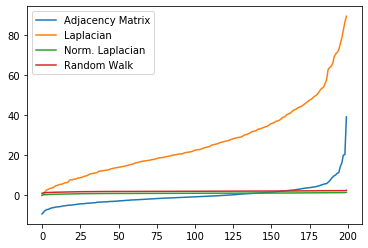

In [11]:
# Returns eigenvalues of the adjacency matrix of G.
lA = nx.adjacency_spectrum(G)
lA = np.sort(lA)

# Returns eigenvalues of the Laplacian of G
lL = nx.laplacian_spectrum(G)
lL = np.sort(lL)

# Return eigenvalues of the normalized Laplacian of G
lN = nx.normalized_laplacian_spectrum(G)
lN = np.sort(lN)

# Returns eigenvalues of the modularity matrix of G.
lM = nx.modularity_spectrum(G)
lM = np.sort(lM)

# Returns eigenvalues of the random walk laplacian matrix of G.
RW_eig, _ = np.linalg.eig(RW)
lRW = np.sort(RW_eig) + 1

# TODO plot the spectrums
fig, ax = plt.subplots(1,1)
ax.plot(lA, label="Adjacency Matrix")
ax.plot(lL, label="Laplacian")
ax.plot(lN, label="Norm. Laplacian")
#ax.plot(lM, label="Modularity")
ax.plot(lRW, label="Random Walk")
ax.legend()

print(lA.sum(), lL.sum(), lN.sum(), lM.sum())

In [141]:
from sklearn.cluster import SpectralClustering
from numpy import inf


print(np.isinf(RW).any())
print(np.isnan(RW).any())


rw_clustering = SpectralClustering(n_clusters=10, affinity='precomputed').fit(A)
nl_clustering = SpectralClustering(n_clusters=10, affinity='precomputed').fit(A)

False
False


In [142]:
import sklearn

In [159]:
clusters = rw_clustering.labels_

def contingency_table(predicted, labels):
    table = np.array([[0 for _ in range(np.max(labels) + 1)] for _ in range(np.max(predicted) + 1)])
    
    for index in range(len(predicted)):
        prediction = predicted[index]
        label = labels[index]
        table[prediction][label] += 1
        
    return table


def label_probability(labels):
    label_count = np.array([0 for i in range(0, 10)])
    
    for l in range(len(labels)):
        label_count[labels[l]] += 1
        
    probability = label_count / np.sum(label_count)
    
    return probability


def entropy(labels):
    probability = label_probability(labels)
    return -np.sum([p * np.log(p) for p in probability])

def i_c_t(labels, clustering):
    label_prob = label_probability(labels)
    clustering_prob = label_probability(clustering)
    
    value = 0.
    
    contingency = contingency_table(clustering, labels)
    
    for i in range(len(label_prob)):
        value_temp = 0
        
        for j in range(len(clustering_prob)):
            p = contingency[j][i] / np.sum(contingency, axis=1)[i]
            
            if p > 0:
                value_temp += p * np.log(p)
            
        value += value_temp * -label_prob[i]
    
    entropy_clusters = entropy(clustering)
    
    return entropy_clusters - value

ours = i_c_t(clusters, y_)
theirs = sklearn.metrics.normalized_mutual_info_score(y_, clusters, average_method='arithmetic')

print(ours)
print(theirs)

1.8891304185177202
0.5025861430367856


### Relationship between DBSCAN and Spectral Clustering
The way in which we construct the epsilon neighborhood graph for spectral clustering is by assigning an edge to all pairs of nodes that are within a certain distance from each other. In DBSCAN, we also group items into the same cluster, if they are within a certain distance from each other. Therefore, the two methods yield similar results.

## 3. Graph embeddings

In this final exercise, we will try a different approach for clustering the data from above.
The strategy is going to be the following:

1. Build a PPR similarity matrix. 
1. Use the similarity matrix with VERSE [[1]](https://arxiv.org/pdf/1803.04742.pdf) to produce embeddings of the nodes in the graph.
2. Use K-Means to cluster the embeddings.

Your task is to i) fill in the methods below to implement the sampling version of VERSE. _Hint:_ it might be a help to look in the original article.
and ii) run K-means on the embeddings to evaluate the performance compared to Spectral clustering using the NMI as measure.

**Report section 3:**  
1. Summary of your experiments.
2. An analysis of the running time of the VERSE code.
3. Can you think to a way of skipping the generation of the PageRank matrix and still preserving the correct distribution? _Hint_: think to what other methods have done.

[[1](https://arxiv.org/pdf/1803.04742.pdf)] Tsitsulin, A., Mottin, D., Karras, P. and Müller, E., 2018, April. Verse: Versatile graph embeddings from similarity measures. In Proceedings of the 2018 World Wide Web Conference (pp. 539-548).

In [ ]:
def sigmoid(x):
    ''' Return the sigmoid function of x 
        x: the input vector
    '''
    ### YOUR CODE HERE
    ### YOUR CODE HERE
    return x

def pagerank_matrix(G, alpha = 0.85) :     
    ''' Return the PPR matrix of a graph

        Args:
            G: the input graph
            alpha: the dumping factor of  PageRank

        :return The nxn PageRank matrix P
    '''
    ### YOUR CODE HERE
    ### YOUR CODE HERE
    return P
    

def update(u, v, Z, C, step_size) :
    '''Update the matrix Z using row-wise gradients of the loss function

       Args:
            u : the first node
            v : the second node
            Z : the embedding matrix
            C : the classification variable used in Noise Contrastive estimation indicating whether the sample is positive or negative
            step_size: step size for gradient descent


       :return nothing, just update rows Z[v,:] and and Z[u,:]
    '''
    ### YOUR CODE HERE
    ### YOUR CODE HERE
    
    
def verse(G, S, d, k = 3, step_size = 0.0025, steps = 10000): 
    ''' Return the sampled version of VERSE

        Args:
            G: the input Graph
            S: the PageRank similarity matrix
            d: dimension of the embedding space
            k: number of negative samples
            step_size: step size for gradient descent
            steps: number of iterations

        :return the embedding matrix nxd
    '''
    n = G.number_of_nodes()
    Z = 1/d*np.random.rand(n,d)

    ### YOUR CODE HERE
    ### YOUR CODE HERE
    
    return Z


In [ ]:
# This code runs the `verse` algorithm above on G and stores the embeddings to 'verse.npy'
P   = pagerank_matrix(G)
emb = verse(G, P, 128, step_size=0.0025, steps=10_000)
np.save('verse.npy', emb)

# TODO
# Run K-means multiple times and choose the best.
# Compare to Spectral clustering on G, according to NMI 

## Deliverables
As part of the handin you must submit the following.

### Code
You must include a `.py` file including your implementations from Exercise 2 and 3. Alternatively, you could code everything in here and upload the final IPython Notebook. 

### Report
Your report should be 1-3 pages and clearly state who is in the group. It must cover:

* Summary/Abstract: The status of the work, i.e., does it work, if not, then why.
* Answers to the report sections stated above.
